# Who will vote for Trump? Quick and Dirty Analysis

###### Author: Jiashen Liu, Data Scientist at Quantillion

Final Objective: To see who will actually vote for Trump based on the survey data. We just consider US data only in the below analysis.

## 0. Load Data From Xlsx 

In [1]:
import pandas as pd

**We put everything in a single data frame for convenience. Since we got two dataset, we create a function to load xls sheet, parser each sheet and put everything together.**

**In each xlsx sheet, the first sheet represents an integrated sheet with all useful information. The other sheet can be viewed as a one-hot-encoding form of the column. So we first remove the column with the same name as one of the sheet and join the remaining part of main table with the corresponding sheet.**

In [2]:
def load_data(data_set):
    xls = pd.ExcelFile(data_set)
    required_tabs = xls.sheet_names
    main_table = xls.parse(required_tabs[0])
    del_col = ['[aud] social_networks_regularly_used','[aud] member_organization','[aud] social_media_activity_rank',
              '[dem] ethnicity','[dem] origin','[question] important_issues_when_voting',
               '[question] preferred_type_of_political_leader',
               '[question] ranking_importance_of_issues_when_voting',
               '[dem] ethnic_background'
              ]
    for col in del_col:
        try:
            del main_table[col]
        except Exception:
            pass
    for i in range(1,len(required_tabs)):
        tmp = xls.parse(required_tabs[i])
        main_table = pd.merge(main_table,tmp,how='left',on=['[meta] uuid','[meta] uuid'])
    return main_table

In [3]:
us_data = load_data('dalia_research_challenge_us.xlsx')

In [4]:
print(us_data.shape)

(1052, 142)


**We got a really wide data set for people's political landscapes of both US and EU.**

## 1. ML Feature Selection

**By using the feature selection mechanism of ML model, we will choose around 10 most important features to analyze the driving force behind people's election behavior. **

In [5]:
del us_data['[meta] uuid']

In [6]:
del us_data['[meta] weight']

In [7]:
del us_data['[dem] country_code']

In [8]:
us_data.head()

,[dem] age,[dem] gender,[dem] education_level,[dem] degree_of_urbanisation,[dem] residency,[dem] household_size,[dem] immigration,[dem] settlement_size,[dem] hometown,[dem] religion,...,Less immigration_y,Better schools_y,Better healthcare_y,Higher wages_y,Higher pensions_y,Better enforcement of law and order_y,Equal rights for minority groups_y,"Lower costs of living (e.g. rent, water, energy)_y","Better public services (e.g. transportation, waste management)_y","Better infrastructure (e.g. roads, sidewalks)_y"
0,46,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",1,My grandparents moved here,Town with 1 000 - 50 000 people,Yes,Buddhist,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",1,My family has been here for a longer time,City with 250 000 - 1 million people,No,Other,...,NaN,4.0,2.0,NaN,NaN,NaN,3.0,5.0,NaN,NaN
2,27,female,I completed high school or obtained an equival...,rural,"Yes, as a citizen",1,My family has been here for a longer time,Town with 1 000 - 50 000 people,Yes,Other,...,4.0,NaN,1.0,NaN,NaN,NaN,5.0,2.0,NaN,NaN
3,37,female,I have completed a university or equivalent de...,city,"Yes, as a citizen",5 or more,My family has been here for a longer time,City with 50 000 - 250 000 people,No,Other,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49,male,I completed high school or obtained an equival...,city,"Yes, as a citizen",3,My family has been here for a longer time,City with 5 million - 10 million people,No,None / not religious,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,3.0,NaN,NaN


**In this case, since the data set is extremely wide, we choose to use machine learning method to decide: which features are more important for US citizen's choice. After trying several models, we will get the feature importance from the result. Then using EDA will be helpful to inteprete the result.**

**The label of data set will be the one people are gonna vote for, either Trump, Clinton, Others or Nobody. Let's first count the number of unique label.**

In [9]:
Label_count = us_data['[question] vote_for_in_us_election'].value_counts().reset_index()

In [10]:
Label_count.columns = ['Choice','Count']

In [11]:
Label_count

,Choice,Count
0,I did not vote,351
1,Donald Trump,319
2,Hillary Clinton,293
3,Other candidate,89


**Let's draw plots for it.**

In [12]:
import matplotlib.pyplot as plt
from ggplot import *
import seaborn as seb

In [13]:
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552"]
plt.pie(
    Label_count['Count'],
    labels=Label_count['Choice'],
    shadow=False,
    colors= colors,
    explode =(0, 0.2, 0, 0),
    startangle=90,
    autopct='%1.1f%%',
    )

([<matplotlib.patches.Wedge at 0x7fba332f7668>,
  <matplotlib.text.Text at 0x7fba33317908>])

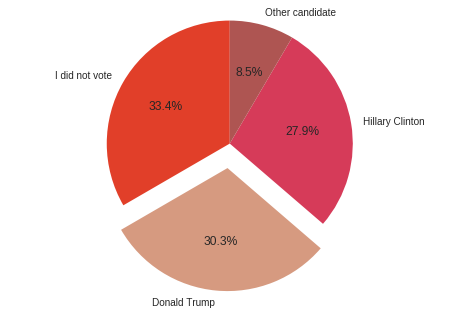

In [14]:
plt.axis('equal')
plt.show()

**Obviously, Trump has the advantage. Otherwise he will not be the president...**

**Let's see which features are most important factors behind people's behaviour. Firstly, we need to deal with the missing values. Quickily set them to -999.**

In [15]:
us_data = us_data.fillna(-999)

**Let's keep the data set and try several classic feature selection methods. We will use models to select features. Models will be: Lasso and Tree models as they are extremely classic. Before everything happens, FACTORIZE DATA!**

In [33]:
us_data_bak = load_data('dalia_research_challenge_us.xlsx')

In [17]:
data_feature = us_data.columns
for each in data_feature:
    us_data[each] = pd.factorize(us_data[each], sort=True)[0]

In [18]:
us_data.head()

,[dem] age,[dem] gender,[dem] education_level,[dem] degree_of_urbanisation,[dem] residency,[dem] household_size,[dem] immigration,[dem] settlement_size,[dem] hometown,[dem] religion,...,Less immigration_y,Better schools_y,Better healthcare_y,Higher wages_y,Higher pensions_y,Better enforcement of law and order_y,Equal rights for minority groups_y,"Lower costs of living (e.g. rent, water, energy)_y","Better public services (e.g. transportation, waste management)_y","Better infrastructure (e.g. roads, sidewalks)_y"
0,32,1,2,0,2,1,2,6,1,0,...,1,0,0,0,0,0,0,0,0,0
1,12,1,2,0,2,1,1,1,0,5,...,0,4,2,0,0,0,3,5,0,0
2,13,0,0,1,2,1,1,6,1,5,...,4,0,1,0,0,0,5,2,0,0
3,23,0,2,0,2,5,1,3,0,5,...,0,0,1,0,0,0,0,0,0,0
4,35,1,0,0,2,3,1,2,0,3,...,0,0,0,2,0,0,0,3,0,0


**As we do not know which model can fit this data set better, I choose to try four classic ML model first to see which one has the best out-of-sample result. Then export the feature importance of model.**

In [19]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(us_data,test_size = 0.2, random_state=42)
features = train.ix[:,train.columns!='[question] vote_for_in_us_election']
label = train['[question] vote_for_in_us_election']

**Simple ML Pipline**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [21]:
Classifiers = [
    LogisticRegression(C=0.01,solver='liblinear',max_iter=300),
    KNeighborsClassifier(4),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=600,random_state=44)]

In [22]:
for clf in Classifiers:
    fit = clf.fit(features,label)
    pred = clf.predict(test.ix[:,test.columns!='[question] vote_for_in_us_election'])
    accuracy = accuracy_score(pred,test['[question] vote_for_in_us_election'])
    print('Accuracy of '+clf.__class__.__name__+'is '+str(accuracy)) 

Accuracy of LogisticRegressionis 0.597156398104
Accuracy of KNeighborsClassifieris 0.473933649289
Accuracy of DecisionTreeClassifieris 0.521327014218
Accuracy of RandomForestClassifieris 0.682464454976


**Pretty bad out-sample accuracy. But the objective is not to train a classifier, so if we just choose the important features, it should be enough to make the decision.**

In [23]:
feature_importance = pd.DataFrame({'Feature':features.columns,'Importance':clf.feature_importances_}).sort_values(['Importance','Feature'],ascending = [0,1])

In [24]:
feature_importance = feature_importance.reset_index()

In [25]:
feature_importance = feature_importance.ix[0:10,:]

In [26]:
feature_importance

,index,Feature,Importance
0,34,[question] vote_next_national_election,0.055431
1,33,[question] frequency_of_voting,0.043411
2,0,[dem] age,0.025959
3,53,[question] gender_discrimination_importance,0.022159
4,119,… has the right experience,0.020141
5,23,[dem] economy_country_next12months,0.018748
6,118,… speaks his / her mind,0.017722
7,55,[question] worldview,0.015910
8,44,[question] country_direction_past5years,0.015219
9,10,[dem] employment_status,0.014802


**Now, ten most important features selected by a machine learning model are provided above. Let us explore them one by one.**

## 2. Exploratory Data Analysis on selected features.

**Let's break them down one by one.**

**A: Vote Next National Election + Voting Frequency**

In [34]:
VNE = us_data_bak.groupby(['[question] vote_next_national_election','[question] vote_for_in_us_election']).size().reset_index()

In [35]:
VNE.columns = ['Vote_Next_Election','Vote_For_Whom','Count']

In [36]:
VNE['Next_Election'] = pd.factorize(VNE['Vote_Next_Election'], sort=True)[0]

In [37]:
VNE

,Vote_Next_Election,Vote_For_Whom,Count,Next_Election
0,I'm not eligible to vote,Donald Trump,7,0
1,I'm not eligible to vote,Hillary Clinton,4,0
2,I'm not eligible to vote,I did not vote,62,0
3,"No, I will definitely not vote",Donald Trump,5,1
4,"No, I will definitely not vote",Hillary Clinton,5,1
5,"No, I will definitely not vote",I did not vote,49,1
6,"No, I will definitely not vote",Other candidate,2,1
7,"No, I will probably not vote",Donald Trump,9,2
8,"No, I will probably not vote",Hillary Clinton,11,2
9,"No, I will probably not vote",I did not vote,82,2


In [38]:
gg = ggplot(VNE,aes(x='Next_Election',weight='Count'))+geom_bar()+ggtitle('Count of Next Election Voting By Different Current Voting Pattern')+facet_wrap('Vote_For_Whom')

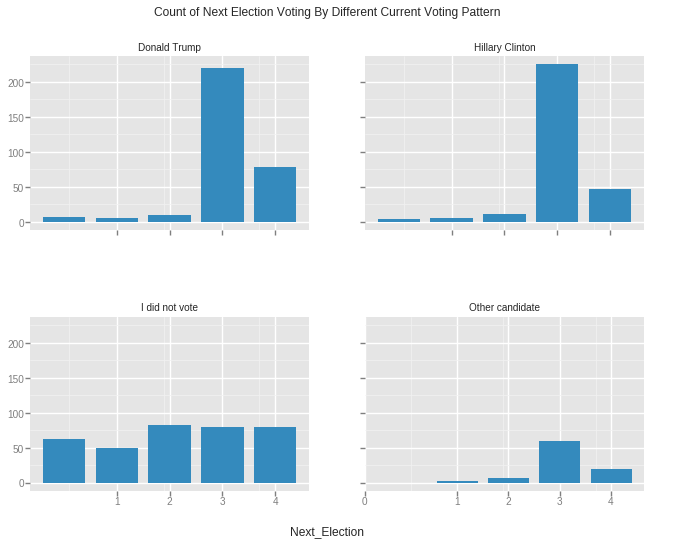

<ggplot: (8777349619748)>

In [39]:
gg

**Where**

In [40]:
VNE.groupby(['Vote_Next_Election','Next_Election']).size()

Vote_Next_Election              Next_Election
I'm not eligible to vote        0                3
No, I will definitely not vote  1                4
No, I will probably not vote    2                4
Yes, I will definitely vote     3                4
Yes, I will probably vote       4                4
dtype: int64

**Voting Frequency seems to be a similar variable here. Although this may cause multicolinearity, but as a EDA we just combine the analysis together.**

In [41]:
print(us_data_bak['[question] frequency_of_voting'].unique())

['Rarely' 'Never' 'I have never been eligible to vote' 'Always'
 'Most of the time' 'Sometimes']


In [42]:
VTF = us_data_bak.groupby(['[question] frequency_of_voting','[question] vote_for_in_us_election']).size().reset_index()

In [43]:
VTF.columns = ['Voting Frequency','Vote For Whom','Count']

In [44]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle']

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2)
facet = VTF['Vote For Whom'].unique()
for ax, lb in zip(axes.flat, facet):
    df = VTF[VTF['Vote For Whom']==lb]
    ax.pie(df['Count'], labels=['','','','','',''], autopct='%.2f')
    ax.set(ylabel='', title=lb, aspect='equal')
axes[0, 0].legend(bbox_to_anchor=(0, 0.5),labels=df['Voting Frequency'])

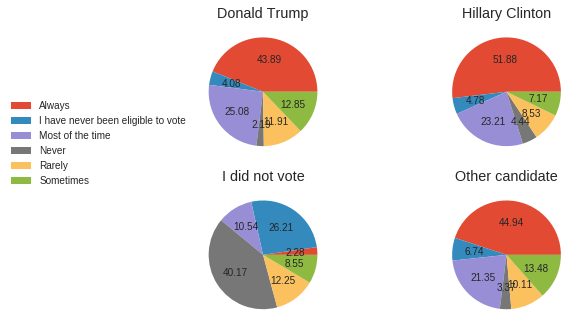

In [46]:
plt.show()

**So, it is obvious to see that: people who have already decided not to vote in the future election do not vote this time. THerefore, it is important to know whether people care about election before guessing his/her political landscape.**

**B: Age Distribution among Voters**

**Let's just quickily go through the Age distribution between different groups.**

In [47]:
gg = ggplot(us_data_bak,aes(x='[dem] age'))+theme_bw()+ geom_density()+facet_wrap('[question] vote_for_in_us_election')

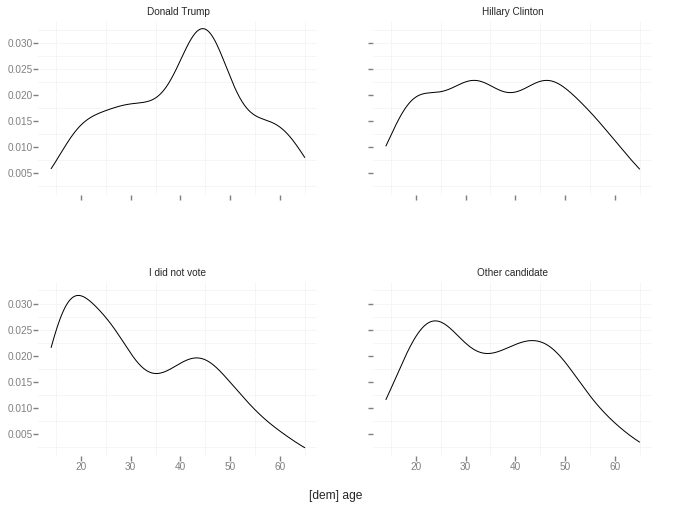

<ggplot: (-9223363259505550220)>

In [48]:
gg

**You can see that people around 40 -50 are more likely ti vote for Trump. ALso, young guys and girls are less likely to vote for someone, seems they do not care.**

**Let's exclude the voters who do not have the right to vote.**

In [49]:
gg = ggplot(us_data_bak[us_data_bak['[question] frequency_of_voting']!='I have never been eligible to vote'],aes(x='[dem] age'))+theme_bw()+ geom_density()+facet_wrap('[question] vote_for_in_us_election')

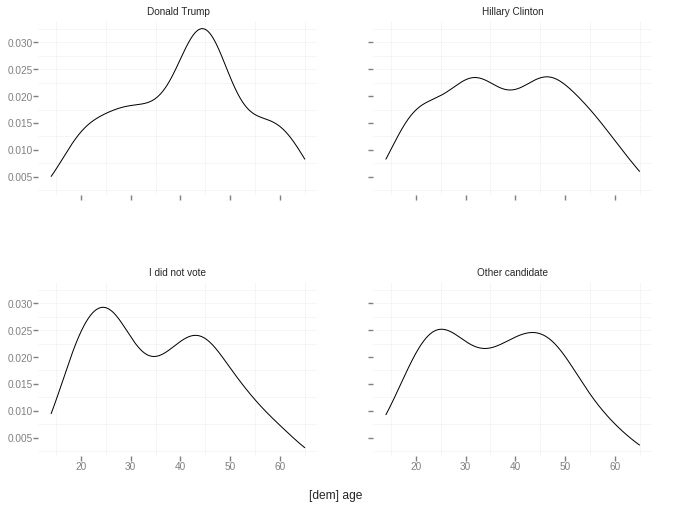

<ggplot: (8777349111458)>

In [50]:
gg

**The shape of histogram of the group who did not to vote has changed. See how many 'useless' individual voters as they probably are not adult. How come they do survey on them!**

**In short, middle-aged voters are more willing to vote for Trump BOSS!**

**C: Gender Descrimination**

In [51]:
print(us_data_bak['[question] gender_discrimination_importance'].unique())

['Yes, somewhat' 'Yes, very' 'No, not really' 'No, not at all']


In [52]:
GDE = us_data_bak.groupby(['[question] gender_discrimination_importance','[question] vote_for_in_us_election']).size().reset_index()

In [53]:
GDE.columns = ['Gender Descrimination Importance','Vote For Whom','Count']

In [54]:
gg = ggplot(GDE,aes(x='Gender Descrimination Importance',weight='Count'))+geom_bar()+facet_wrap('Vote For Whom')

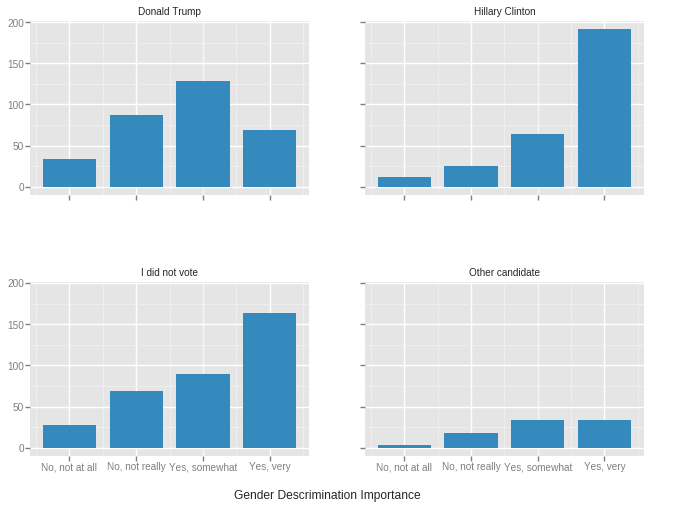

<ggplot: (-9223363259505794009)>

In [55]:
gg

**That says something. We can see that a lot of Trump's supporters do not really think that Gender Descrimination matters! In contrary, as the traditional political rockstar, Clinton's support does care about this issue.**

In [58]:
us_data_bak['Monthly_Income_Num'] = us_data_bak['[dem] income_net_monthly'].apply(lambda x:transfer_income(x))

**D: Voter's idea about country's past and future**

In [69]:
print(us_data_bak['[dem] economy_country_next12months'].unique())

['… get a little worse' "Don't know" '… get a little better'
 '… stay the same' '… get a lot better' '… get a lot worse']


In [71]:
print(us_data_bak['[question] country_direction_past5years'].unique())

['… somewhat wrong' '… neither wrong nor right' '… very wrong'
 '… somewhat right' '… very right']


In [92]:
def Score_PF(phase,term):
    if phase =='Past':
        if term == '… very wrong':
            return -2
        elif term == '… somewhat wrong':
            return -1
        elif term == '… neither wrong nor right':
            return 0
        elif term == '… somewhat right':
            return 1
        else:
            return 2
    else:
        if term== '… get a lot worse':
            return  -2
        elif term == '… get a little worse':
            return -1
        elif term == '… get a little better':
            return 1
        elif term == '… get a lot better':
            return 2
        else:
            return 0      

In [93]:
PAF = us_data_bak.groupby(['[dem] economy_country_next12months','[question] country_direction_past5years','[question] vote_for_in_us_election']).size().reset_index()

In [94]:
PAF.columns = ['Future','Past','Vote for Whom','Count']

In [95]:
PAF['Future_Score'] = PAF['Future'].apply(lambda x:Score_PF('Future',x))

In [96]:
PAF['Past_Score'] = PAF['Past'].apply(lambda x:Score_PF('Past',x))

In [99]:
gg = ggplot(PAF,aes(x='Future_Score',y='Past_Score'))+geom_point(aes(size='Count'))+facet_wrap('Vote for Whom')

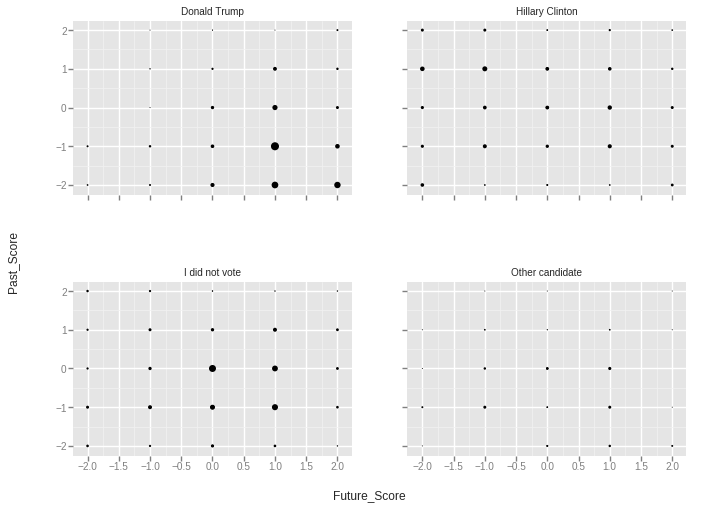

<ggplot: (-9223363259506325525)>

In [100]:
gg

**Let's first put some explanations on the scoring system. Either Past or future, larger scores represent more positive attitude. So we can see that, Trump's supporters are gonna have a negative attitude for the past five years, but are quite confident about the future. Hillary, on the other hands, has the supporters who are ok with the past but not the future. So they want to stay the same.**

**E: People's employment status and Wordview**

In [117]:
def employ_score(text):
    if text=='Not employed, currently NOT looking for work':
        return 'No Work No Look'
    elif text == 'Not employed, currently looking for work':
        return 'No Work Look'
    elif text == 'Disabled, not able to work':
        return 'No Work Ability'
    elif text == 'Self\xad-employed / Freelancer':
        return 'FreeLancer'
    elif text == 'Employed, working 1 to \xad29 hours per week':
        return '1-29 Hrs'
    elif text == 'Employed, working 30 or more hours per week':
        return '30+ Hrs'
    elif text == 'In school, university or practical training':
        return 'Student'
    elif text == 'Entrepreneur / Employer':
        return 'Employer'
    else:
        return 'Unknown'

In [119]:
def wordview(text):
    if text == 'Our lives are threatened by terrorists, criminals, and immigrants and our priority should be to protect ourselves.':
        return 'Negative'
    else:
        return 'Positive'

In [184]:
ESW['Vote for Whom'].unique()

array(['Donald Trump', 'Hillary Clinton', 'I did not vote',
       'Other candidate'], dtype=object)

In [185]:
def Name_Trans(name):
    if name=='Donald Trump':
        return 'DT'
    elif name=='Hillary Clinton':
        return 'HC'
    elif name =='I did not vote':
        return 'ID'
    else:
        return 'Others'

In [103]:
ESW = us_data_bak.groupby(['[dem] employment_status','[question] worldview','[question] vote_for_in_us_election']).size().reset_index()

In [107]:
ESW.columns = ['Employment_Status','World_View','Vote for Whom','Count']

In [120]:
ESW['Employment'] = ESW['Employment_Status'].apply(lambda x:employ_score(x))

In [121]:
ESW['WorldView'] = ESW['World_View'].apply(lambda x:wordview(x))

In [128]:
gg = ggplot(ESW,aes(x='Vote for Whom',weight='Count'))+geom_bar()+facet_wrap('WorldView')

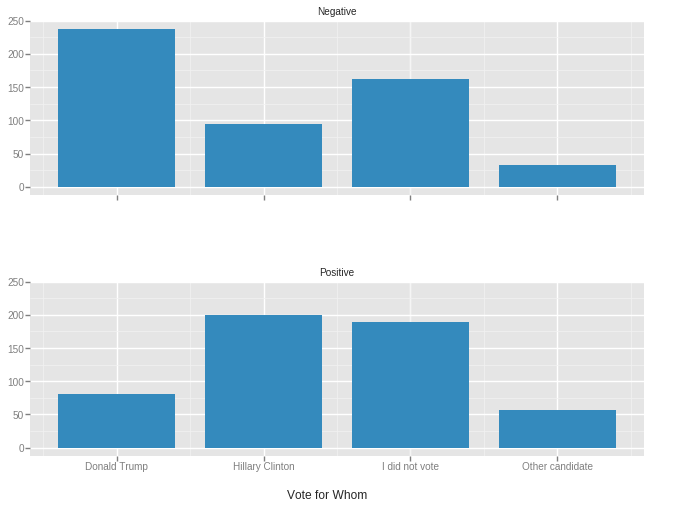

<ggplot: (-9223363259510251744)>

In [129]:
gg

In [186]:
ESW['Vote for Whom Abbr']=ESW['Vote for Whom'].apply(lambda x:Name_Trans(x))

In [187]:
gg = ggplot(ESW,aes(x='Vote for Whom Abbr',weight='Count'))+geom_bar()+facet_wrap('Employment')

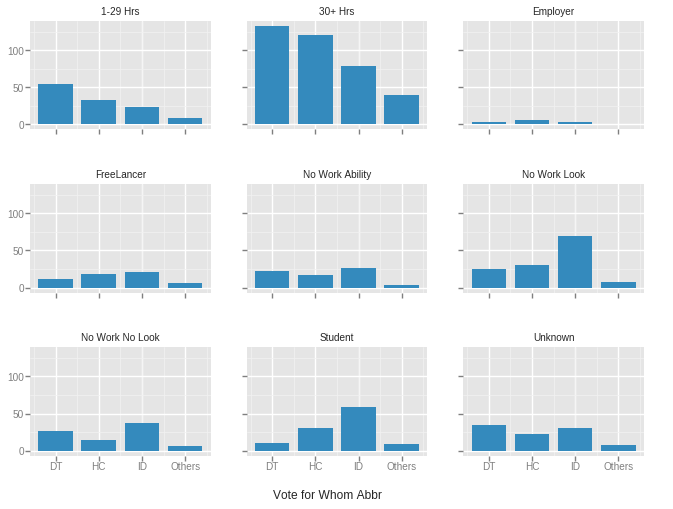

<ggplot: (8777338963299)>

In [188]:
gg

**Trump's supporters are mostly have negative attitiude against immigrants. ALso, Student are more likely to support Clinton, while many people who support Trump will not always have a stable job.**

## 3. Short Conclusion

This analysis is quite quick and dirty... Suitable for a event like recruitment. Overall pipeline: Data loading and transformation --- ML for feature seletion ---EDA for visualization and analysis. Maybe a good pipeline for a quite wide data set with many variables yet no time to go through them one by one.